In [9]:
import gym
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

warnings.filterwarnings("ignore")

In [10]:
class SARSA:
    def __init__(self, bin_list, num_episodes, gamma, epsilon, alpha, max_steps):
        self.bin_list = bin_list
        self.num_episodes = num_episodes
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha  # 학습률 추가
        self.max_steps = max_steps

    def discretize(self, obs):
        idxs = [
            min(max(np.digitize(o, b) - 1, 0), len(b) - 1)
            for o, b in zip(obs, self.bin_list)
        ]
        return tuple(idxs)

    def decay_epsilon(self, rewards_log):
        if len(rewards_log) == 10:
            self.best_reward = np.mean(rewards_log[-10:])

        elif len(rewards_log) > 10 and len(rewards_log) % 100 == 0:
            avg_reward = np.mean(rewards_log[-10:])  # 최근 10개 보상 평균
            if avg_reward > self.best_reward:  # 최고 보상을 갱신하면 감소
                self.best_reward = avg_reward
                self.epsilon = max(0, self.epsilon * 0.995)

    def fit(self, env, Q):
        rewards_log = []

        for _ in tqdm(range(self.num_episodes)):
            obs, info = env.reset()
            state = self.discretize(obs)

            self.decay_epsilon(rewards_log)

            # ε-탐욕적으로 초기 행동 선택
            if random.random() < self.epsilon:
                action = random.randint(0, 1)
            else:
                action = np.argmax(Q[state])

            total_reward = 0

            for _ in range(self.max_steps):
                obs_next, reward, done, truncated, info = env.step(action)
                next_state = self.discretize(obs_next)

                # 다음 행동 a'도 ε-탐욕적으로 선택 (SARSA 방식)
                if random.random() < self.epsilon:
                    next_action = random.randint(0, 1)
                else:
                    next_action = np.argmax(Q[next_state])

                # SARSA 업데이트 식 적용
                Q[state][action] += self.alpha * (reward + self.gamma * Q[next_state][next_action] - Q[state][action])

                total_reward += reward
                state, action = next_state, next_action  # 다음 상태, 행동으로 이동

                if done or truncated:
                    break

            rewards_log.append(total_reward)

        env.close()
        return Q, rewards_log


In [11]:
# 1) 환경 & 이산화 준비
env = gym.make('CartPole-v1')
num_bins = 8
# 관측 범위
ranges = [(-4.8, 4.8), (-3, 3), (-0.418, 0.418), (-4, 4)]
bins_list = [np.linspace(lo, hi, num_bins) for (lo, hi) in ranges]

# 2) Q, 카운트(점진적 평균)
Q = defaultdict(lambda: np.zeros(env.action_space.n, dtype=np.float32))

In [12]:
SA = SARSA(bins_list, num_episodes=50000, gamma=0.99, epsilon=0.05, alpha=0.1, max_steps=1000)
Q, rewards = SA.fit(env, Q)

100%|██████████| 50000/50000 [00:34<00:00, 1461.27it/s]


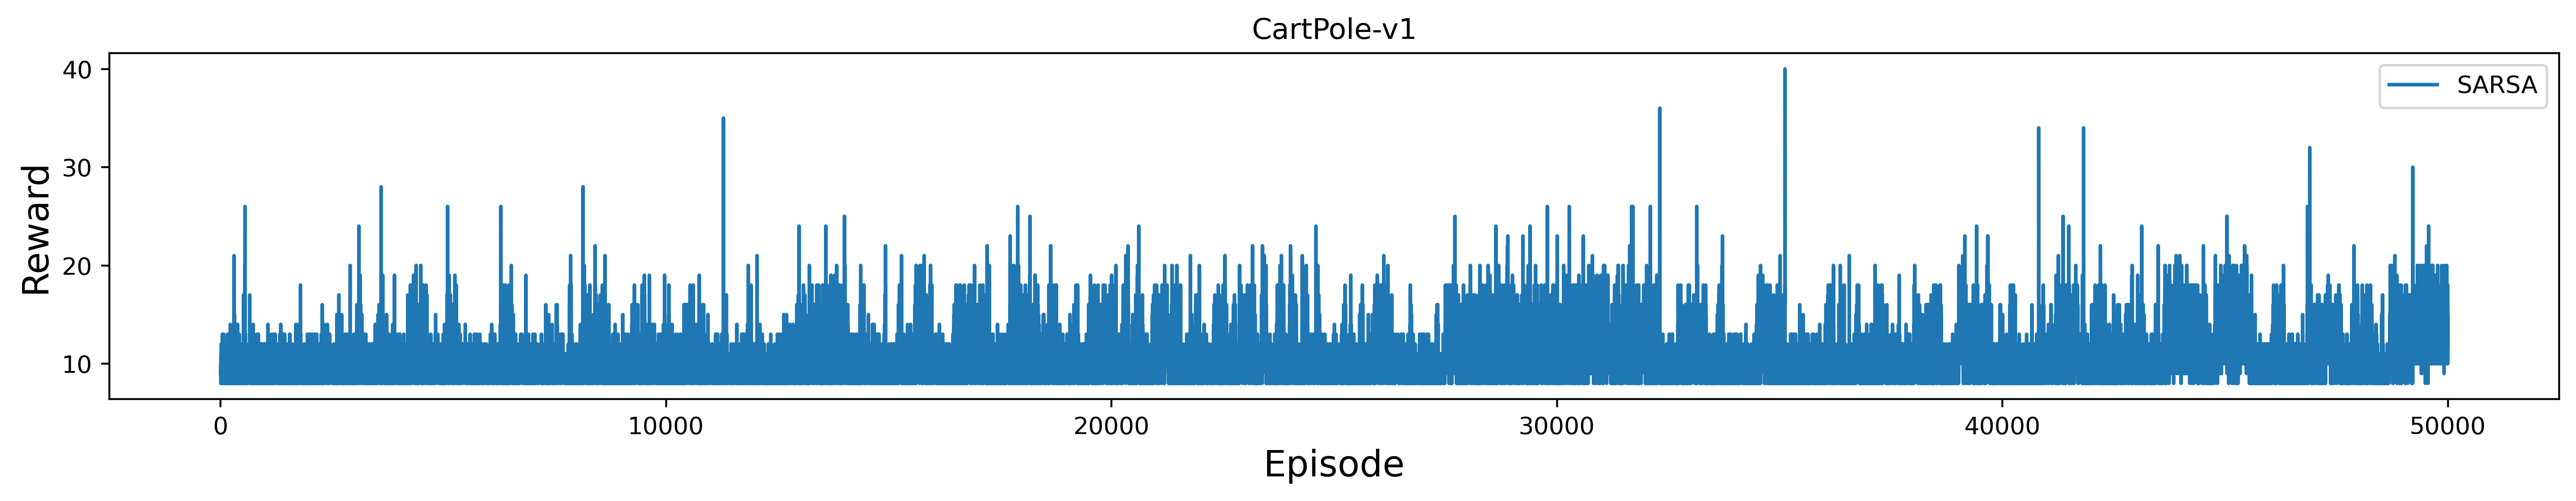

초반 10개 에피소드 보상: [9.0, 9.0, 9.0, 10.0, 10.0, 8.0, 11.0, 9.0, 10.0, 9.0]
마지막 10개 에피소드 보상: [10.0, 14.0, 12.0, 10.0, 16.0, 12.0, 18.0, 10.0, 15.0, 12.0]
최근 100 에피소드 평균 보상: 13.43


In [14]:
plt.figure(figsize=(15, 3), dpi=400)
plt.plot(np.array(rewards), label="SARSA")
plt.title('CartPole-v1')
plt.xlabel('Episode', fontsize=15)
plt.ylabel('Reward', fontsize=15)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print("초반 10개 에피소드 보상:", rewards[:10])
print("마지막 10개 에피소드 보상:", rewards[-10:])
avg_reward_recent = np.mean(rewards[-100:])
print(f"최근 100 에피소드 평균 보상: {avg_reward_recent:.2f}")